In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score

import shap

# Проект: Обучение с учителем: качество модели

## Описание

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Задача - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Загрузка данных

Загрузим данные и проведём беглый анализ таблиц

In [2]:
try:
    df_market_file = pd.read_csv('./datasets/market_file.csv')
    df_market_money = pd.read_csv('./datasets/market_money.csv')
    df_market_time = pd.read_csv('./datasets/market_time.csv')
    df_money = pd.read_csv('./datasets/money.csv', sep=';')
except:
    df_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

In [3]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [4]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [6]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [8]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [10]:
df_money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


**Вывод**    
В результате выполнения этапа были загружены и осмотрены все таблицы с данными. У данных обнаружена следующая проблема:
- У столбца "Прибыль" в таблице с выручкой тип object, хотя должен быть float. Проблема будет устранена на этапе предобработки

## Предобработка данных

Проверим все таблицы на пропуски, явные/неявные дупликаты, исправим типы данных

In [11]:
df_market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [12]:
df_market_file.duplicated().sum()

0

In [13]:
df_market_file['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [14]:
df_market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [15]:
df_market_file.loc[df_market_file['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
df_market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [16]:
df_market_file['Разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [17]:
df_market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [18]:
df_market_money.duplicated().sum()

0

In [19]:
df_market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [20]:
df_market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [21]:
df_market_time.duplicated().sum()

0

In [22]:
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [23]:
df_market_time.loc[df_market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [24]:
df_money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [25]:
df_money.duplicated().sum()

0

In [26]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [27]:
df_money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [28]:
df_money['Прибыль'] = pd.to_numeric(df_money['Прибыль'].str.replace(',', '.'), errors='coerce')
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод**
В результате предобработки данных:
- Пропуски не обнаружены
- Удалены неявные дупликаты в столбце "Тип сервиса" в таблице с основными данными
- Удалены неявные дупликаты в столбце "Период" в таблице с данными о проведённом пользователями времени
- Исправлен тип данных у столбца "Прибыль" в таблице с данными о выручке

Данные готовы к работе

## Исследовательский анализ данных

Проведём исследовательский анализ данных во всех таблицах, перед этим отобрав только активных пользователей

In [29]:
df_filtered = df_market_money[df_market_money['Период'].isin(['предыдущий_месяц', 'препредыдущий_месяц'])]
user_revenue = df_filtered.groupby('id')['Выручка'].sum().reset_index()
active_users = user_revenue[user_revenue['Выручка'] > 0]['id'].tolist()

df_market_file = df_market_file[df_market_file['id'].isin(active_users)]
df_market_time = df_market_time[df_market_time['id'].isin(active_users)]
df_market_money = df_market_money[df_market_money['id'].isin(active_users)]
df_money = df_money[df_money['id'].isin(active_users)]

print(df_market_file.shape, df_market_time.shape, df_market_money.shape, df_money.shape)

(1297, 13) (2594, 3) (3891, 3) (1297, 2)


In [30]:
# Универсальная функция для анализа всех таблиц
def eda_report(df):
    # Гистограммы для числовых признаков
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    df[numerical_cols].hist(bins=30, figsize=(15, 10))
    plt.tight_layout()
    plt.show()

    # Плотность распределения
    df[numerical_cols].plot(kind='density', subplots=True, layout=(3, 3), 
                           sharex=False, figsize=(15, 10))
    plt.tight_layout()
    plt.show()

    # Анализ категориальных признаков
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_cols:
        print(f"\nСтатистика для {col}:")
        print(df[col].value_counts())
        print(f"Количество уникальных значений: {df[col].nunique()}")
    
        # Визуализация
        if df[col].nunique() < 20:  # если не слишком много категорий
            df[col].value_counts().plot(kind='bar')
            plt.title(f'Распределение {col}')
            plt.show()

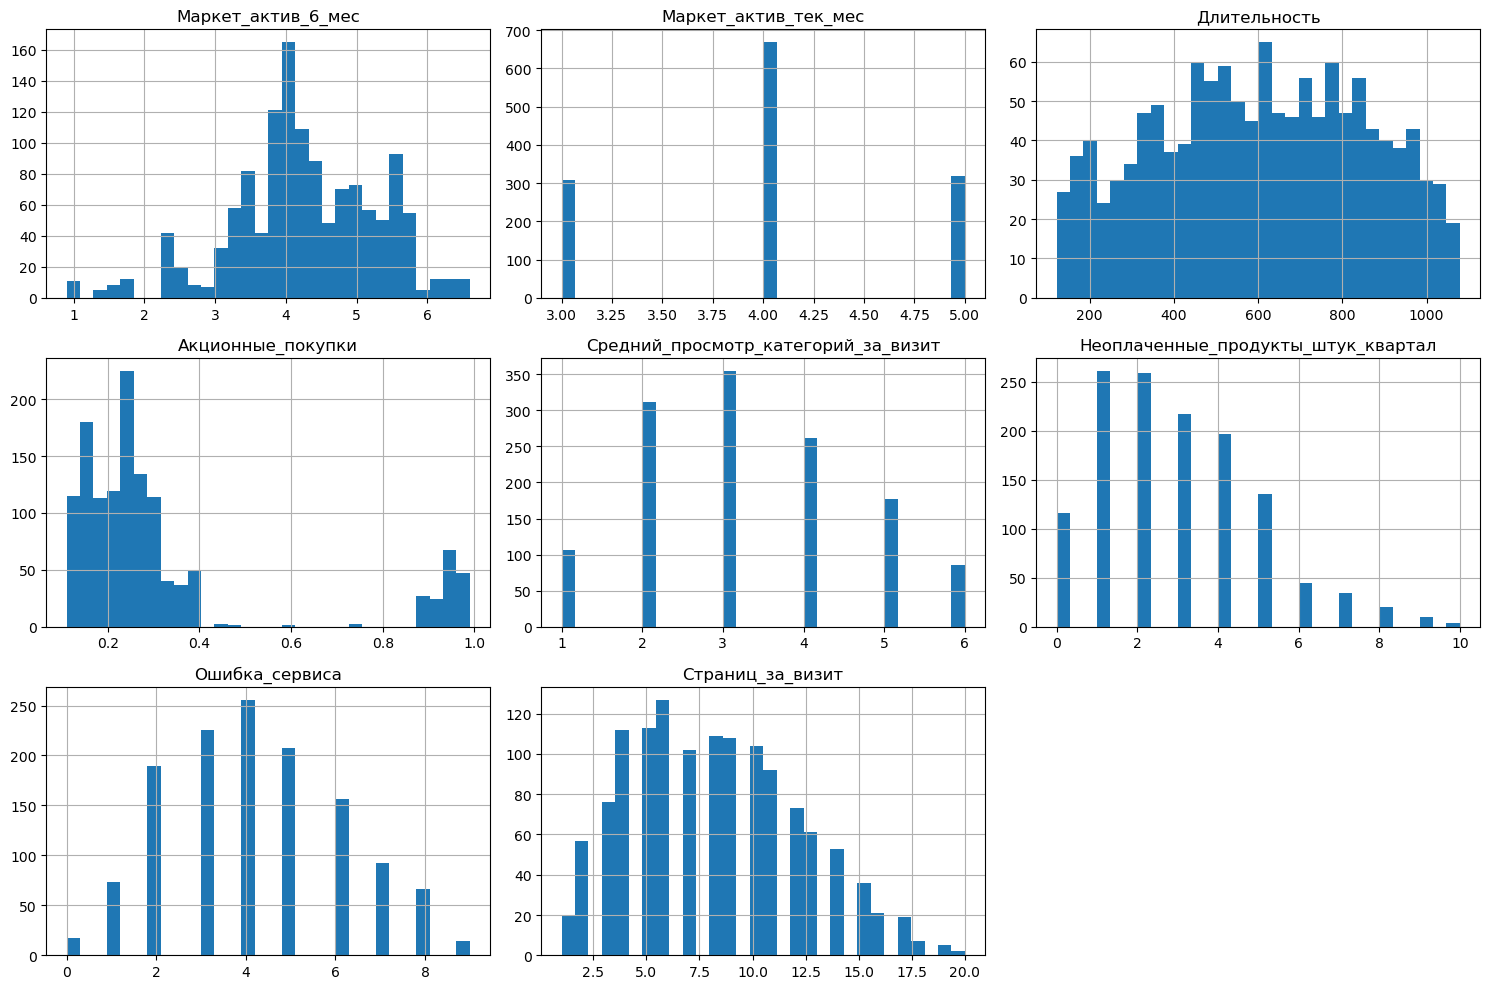

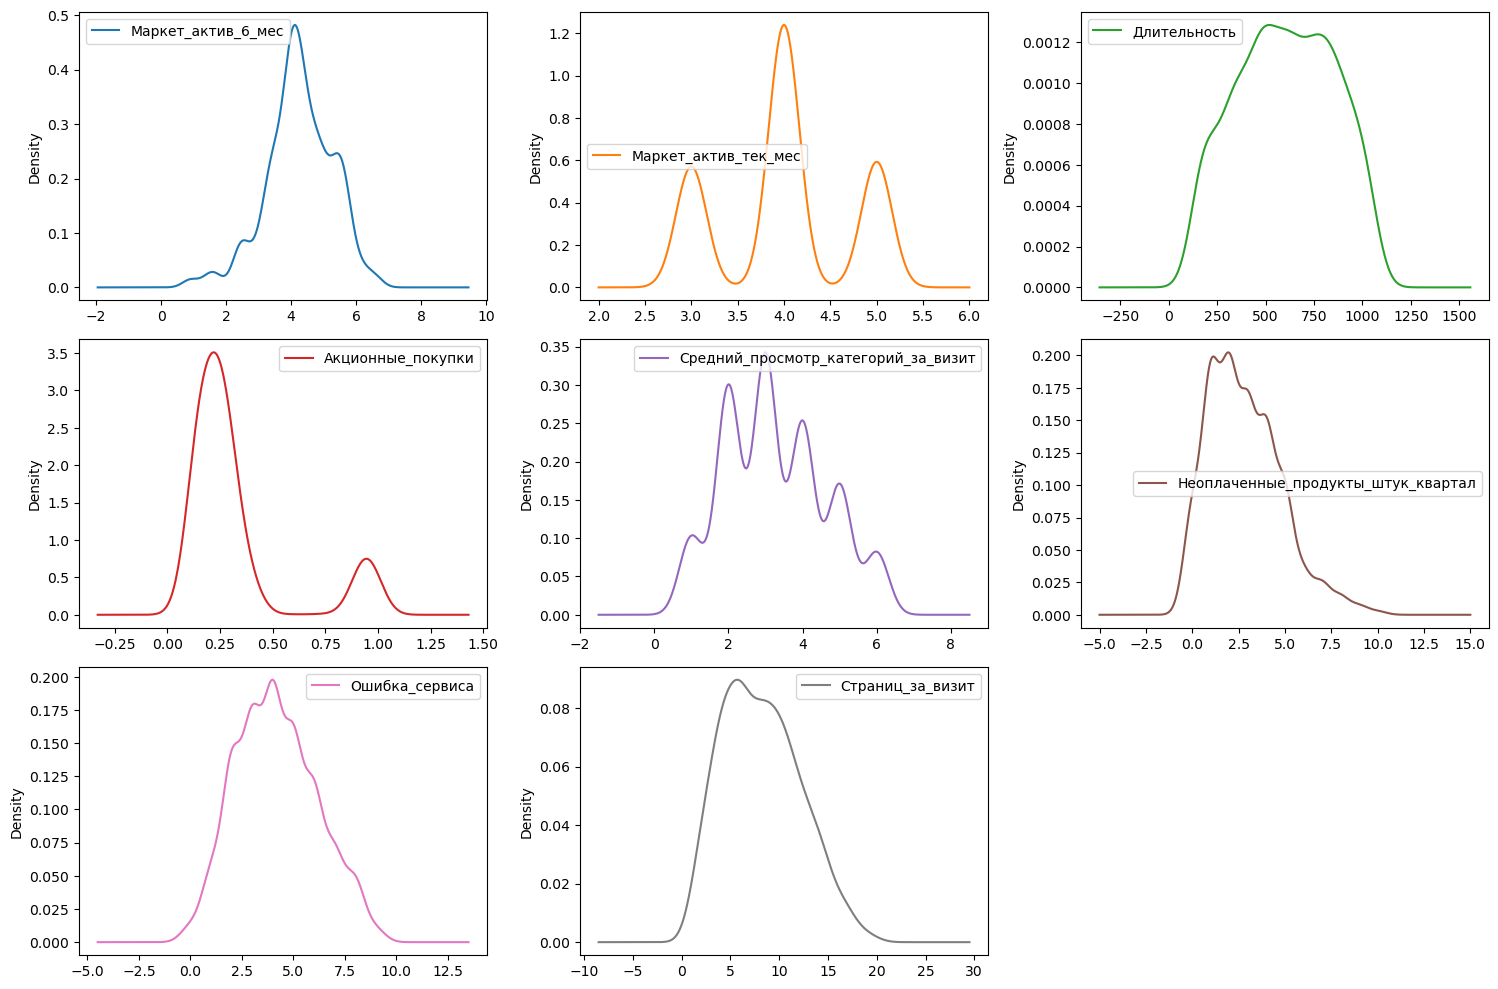


Статистика для Покупательская активность:
Покупательская активность
Прежний уровень    802
Снизилась          495
Name: count, dtype: int64
Количество уникальных значений: 2


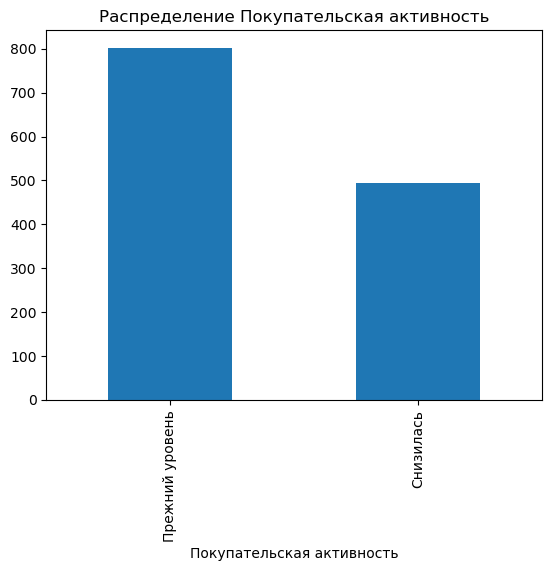


Статистика для Тип сервиса:
Тип сервиса
стандарт    922
премиум     375
Name: count, dtype: int64
Количество уникальных значений: 2


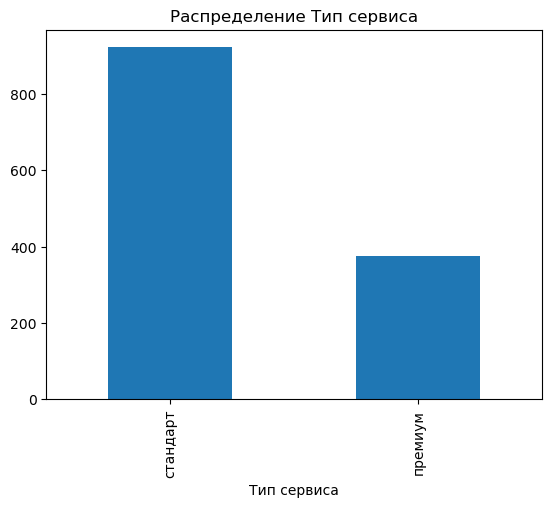


Статистика для Разрешить сообщать:
Разрешить сообщать
да     959
нет    338
Name: count, dtype: int64
Количество уникальных значений: 2


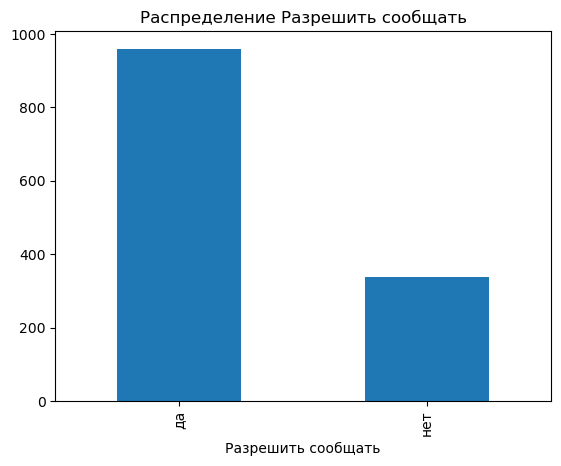


Статистика для Популярная_категория:
Популярная_категория
Товары для детей                        329
Домашний текстиль                       250
Косметика и аксесуары                   223
Техника для красоты и здоровья          183
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64
Количество уникальных значений: 6


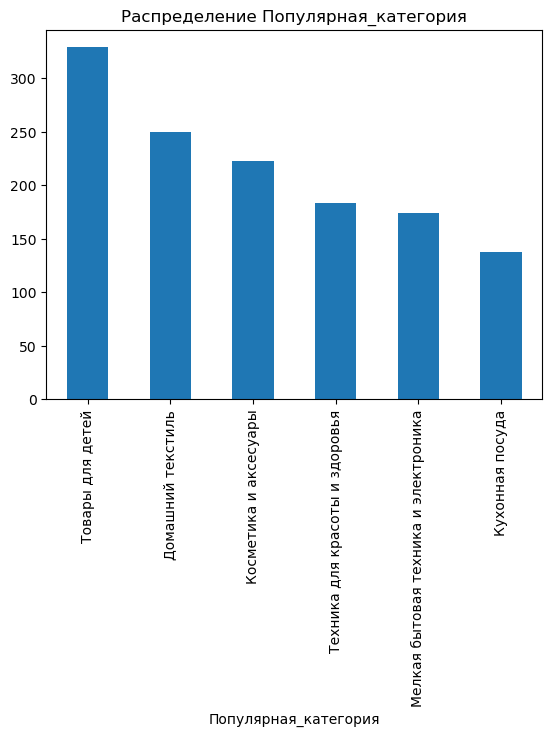

In [31]:
eda_report(df_market_file.drop('id', axis=1))

**Особенности данных** в market_file:
- Есть чёткое разделение пользователей в рамках акционных покупок: "Мало" и "Много"
- У остальных величин распределение близко к нормальному
- Количество пользователей с премиум сервисом кратно меньше стандартных пользователей
- Самая популярная категория - "Товары для детей". Самая не популярная - "Кухонная посуда"

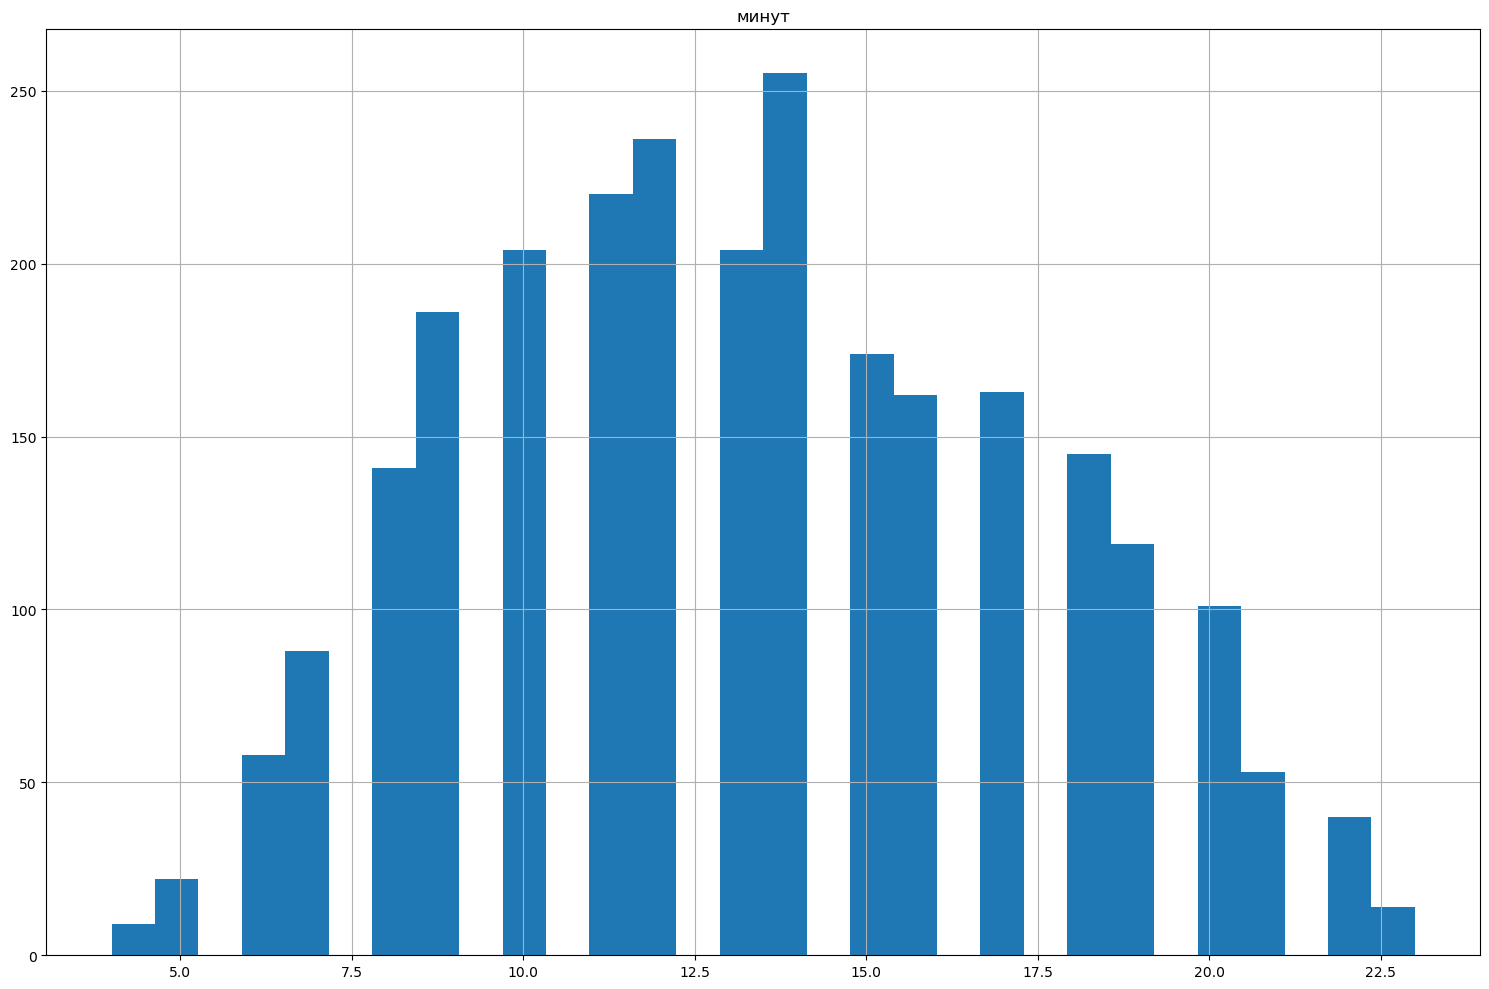

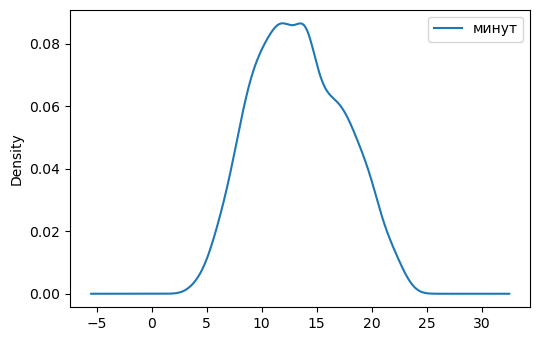


Статистика для Период:
Период
текущий_месяц       1297
предыдущий_месяц    1297
Name: count, dtype: int64
Количество уникальных значений: 2


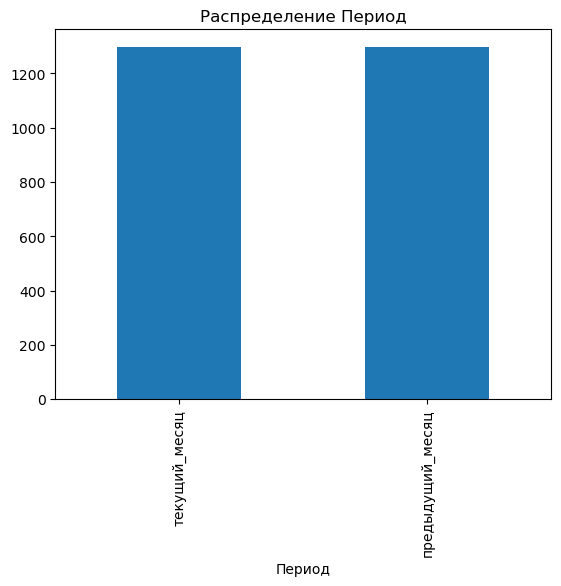

In [32]:
eda_report(df_market_time.drop('id', axis=1))

**Особенности данных** в market_time:
- Время распределено нормально

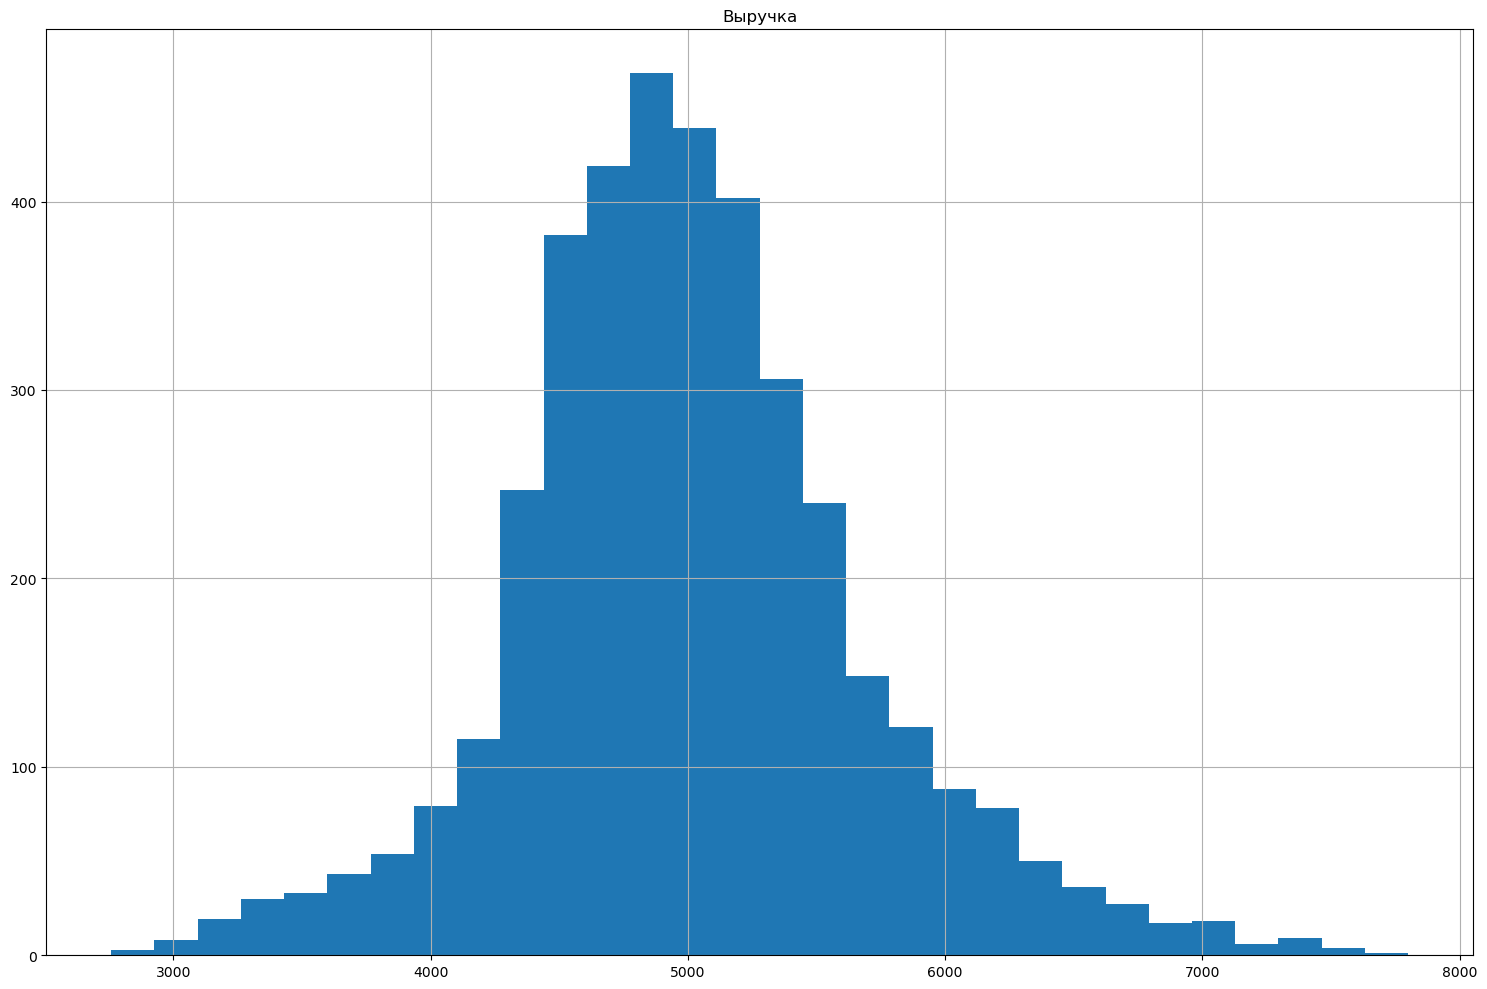

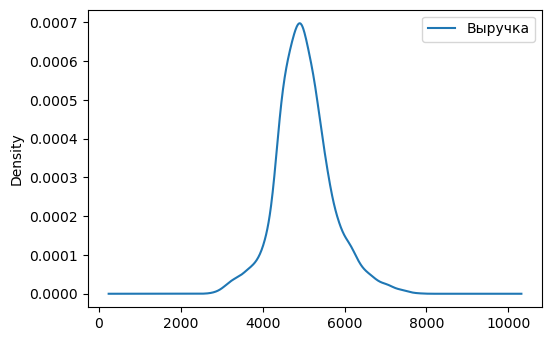


Статистика для Период:
Период
препредыдущий_месяц    1297
предыдущий_месяц       1297
текущий_месяц          1296
Name: count, dtype: int64
Количество уникальных значений: 3


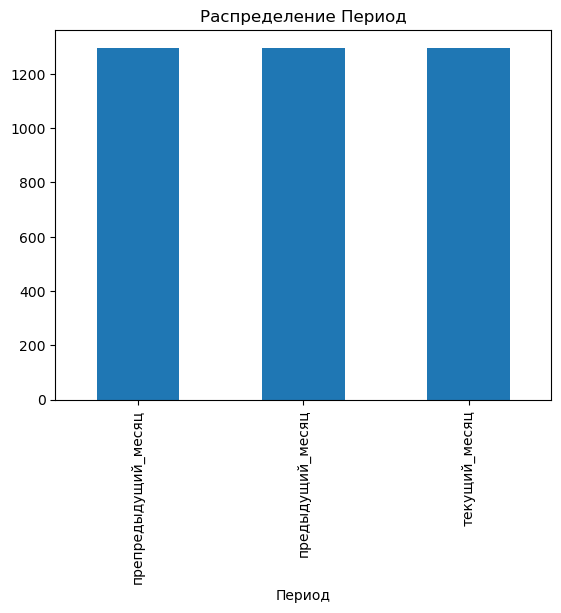

In [33]:
eda_report(df_market_money.drop('id', axis=1).query('Выручка < 40000'))

<Axes: ylabel='Выручка'>

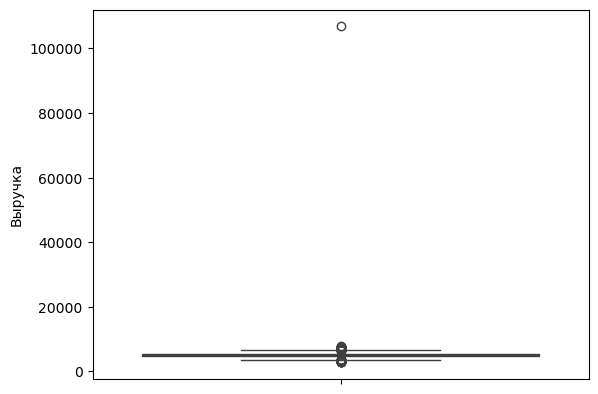

In [34]:
sns.boxplot(data=df_market_money, y='Выручка')

**Особенности данных** в market_money:
- Замечен один пользователь с выручкой > 100000, что является выбросом, его нужно убрать из всех таблиц
- Сама же выручка распределена нормально

In [35]:
anomal_user = df_market_money.query('Выручка > 40000')['id'].tolist()
df_market_file = df_market_file[~df_market_file['id'].isin(anomal_user)]
df_market_time = df_market_time[~df_market_time['id'].isin(anomal_user)]
df_market_money = df_market_money[~df_market_money['id'].isin(anomal_user)]
df_money = df_money[~df_money['id'].isin(anomal_user)]

print(df_market_file.shape, df_market_time.shape, df_market_money.shape, df_money.shape)

(1296, 13) (2592, 3) (3888, 3) (1296, 2)


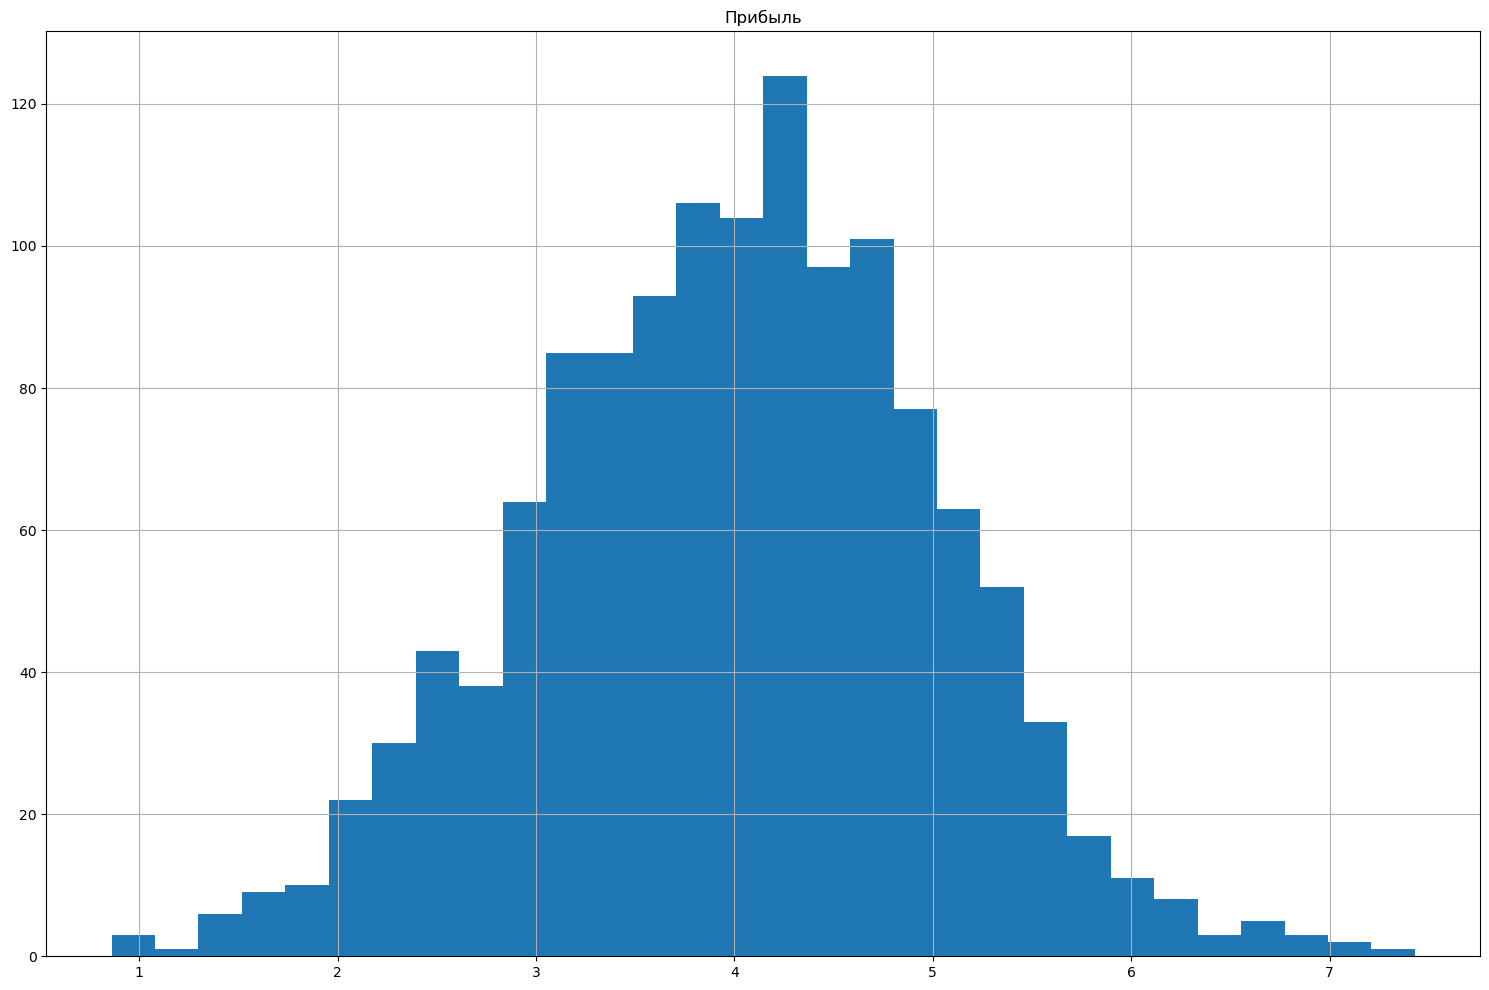

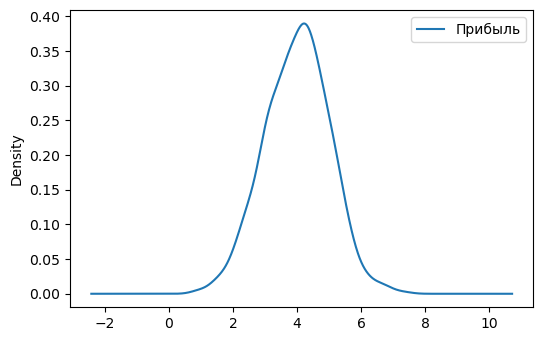

In [36]:
eda_report(df_money.drop('id', axis=1))

**Особенности данных** в money:
- Прибыль распределена нормально

**Вывод**    
В результате исследовательского анализа данных у них были выявлены следующие особенности:
- Есть чёткое разделение пользователей в рамках акционных покупок: "Мало" и "Много"
- У остальных величин распределение близко к нормальному
- Количество пользователей с премиум сервисом кратно меньше стандартных пользователей
- Самая популярная категория - "Товары для детей". Самая не популярная - "Кухонная посуда"
- Время распределено нормально
- Замечен один пользователь с выручкой > 100000, что является выбросом, он убран из всех таблиц
- Выручка распределена нормально

## Объединение таблиц

Объединим все таблицы в одну, сохраняя записи о выручке и времени по периодам

In [37]:
# Функция для преобразования таблиц в широкий формат
def pivot_table(df, value_col, prefix):
    """Преобразует таблицу из длинного в широкий формат"""
    pivoted = df.pivot_table(
        index='id',
        columns='Период',
        values=value_col,
        aggfunc='first'  # или 'sum', если у одного пользователя несколько записей за период
    ).reset_index()
    
    # Переименовываем столбцы
    pivoted.columns = ['id'] + [f'{prefix}_{col}' for col in pivoted.columns[1:]]
    
    return pivoted

# Преобразуем таблицу времени
time_pivot = pivot_table(df_market_time, 'минут', 'Время')

# Преобразуем таблицу выручки
revenue_pivot = pivot_table(df_market_money, 'Выручка', 'Выручка')

# Объединяем все таблицы
df = df_market_file.copy()

# Последовательно объединяем с таблицей времени и выручки
df = pd.merge(df, time_pivot, on='id', how='left')
df = pd.merge(df, revenue_pivot, on='id', how='left')

# Заполняем пропущенные значения нулями (если нужно)
df = df.fillna(0)

print("Итоговая таблица:")
print(df)

Итоговая таблица:
          id Покупательская активность Тип сервиса Разрешить сообщать  \
0     215349                 Снизилась     премиум                 да   
1     215350                 Снизилась    стандарт                нет   
2     215351                 Снизилась    стандарт                 да   
3     215352                 Снизилась    стандарт                нет   
4     215353                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1291  216643           Прежний уровень    стандарт                 да   
1292  216644           Прежний уровень    стандарт                нет   
1293  216645           Прежний уровень    стандарт                 да   
1294  216646           Прежний уровень    стандарт                 да   
1295  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    4.4                 

**Вывод**    
Размерность итоговой таблицы совпадает с размерностью исходной таблицы market_file, объединение прошло успешно

## Корреляционный анализ

Проведём корреляционный анализ признаков, если будет обнаружены признаки с высокой корреляцией - удалим

In [38]:
def preprocess_data(df):
    df_processed = df.copy()
    
    for column in df_processed.columns:
        if df_processed[column].dtype == 'object':
            # Преобразуем строки в категориальные коды
            df_processed[column] = pd.Categorical(df_processed[column]).codes
    
    return df_processed

# Применяем преобразование
data_processed = preprocess_data(df)
data_processed.drop('id', axis=1, inplace=True)

<Axes: >

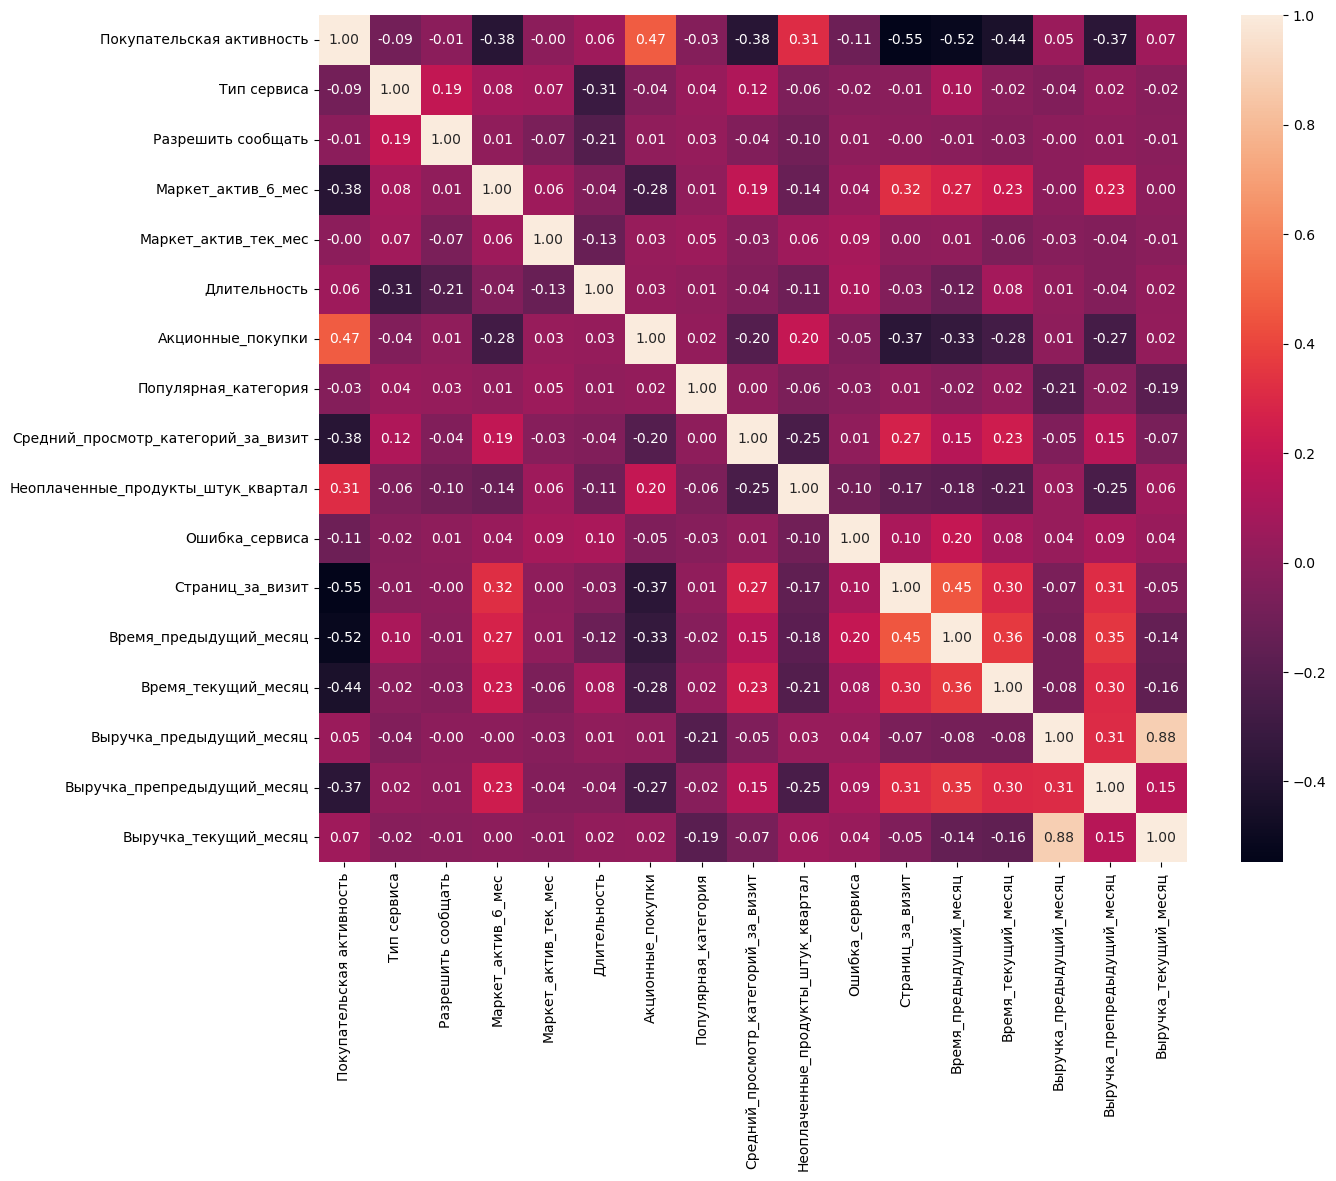

In [39]:
plt.figure(figsize=(14, 11))
sns.heatmap(data_processed.corr(method='spearman'), annot=True, fmt='.2f') 

Выручка за предыдущий месяц имеет высокую корреляцию с выручкой за текущий месяц, удалим признак "Выручка_предыдущий_месяц"

Осмотрим матрицу корреляции после удаления признака

**Вывод**    
В результате корреляционного анализа признаков была исключена мультиколлинеарность в виде признака "Выручка_предыдущий_месяц"

## Использование пайплайнов

Во время подготовки данных будем использовать ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков будем использовать OneHotEncoder и OrdinalEncoder, для масштабирования количественных — StandardScaler и MinMaxScaler. В качестве метрики будем использовать roc_auc, т.к. нам важно, чтобы модель различала классы

In [40]:
RANDOM_STATE=52
TEST_SIZE=0.25

In [41]:
df = df.set_index('id')

X = df.drop(['Покупательская активность'], axis=1)
y = df['Покупательская активность']

ohe_columns = ['Популярная_категория']
ord_columns = ['Разрешить сообщать', 'Тип сервиса']
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [42]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['нет', 'да'],
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [43]:
data_preprocessor.get_feature_names_out()

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [44]:
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

tree_param_grid = {
        'models__max_depth': [None, 5, 10, 15, 20],
        'models__min_samples_split': [2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

grid_search_tree = GridSearchCV(
    pipe_tree, 
    tree_param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_tree.fit(X_train, y_train)

print('Лучшая модель и её параметры:', grid_search_tree.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_tree.best_score_)

Лучшая модель и её параметры: {'models__max_depth': 5, 'models__min_samples_split': 10, 'preprocessor__num': MinMaxScaler()}
Метрика лучшей модели на тренировочной выборке: 0.8542437271982726


In [51]:
grid_search_tree.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

array(['ohe__Популярная_категория_Косметика и аксесуары',
       'ohe__Популярная_категория_Кухонная посуда',
       'ohe__Популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__Популярная_категория_Техника для красоты и здоровья',
       'ohe__Популярная_категория_Товары для детей',
       'ord__Разрешить сообщать', 'ord__Тип сервиса',
       'num__Маркет_актив_6_мес', 'num__Маркет_актив_тек_мес',
       'num__Длительность', 'num__Акционные_покупки',
       'num__Средний_просмотр_категорий_за_визит',
       'num__Неоплаченные_продукты_штук_квартал', 'num__Ошибка_сервиса',
       'num__Страниц_за_визит', 'num__Время_предыдущий_месяц',
       'num__Время_текущий_месяц', 'num__Выручка_предыдущий_месяц',
       'num__Выручка_препредыдущий_месяц', 'num__Выручка_текущий_месяц'],
      dtype=object)

In [47]:
pipe_knn = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid_knn = {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_neighbors': range(2, 5),
    }

grid_search_knn = GridSearchCV(
    pipe_knn, 
    param_grid_knn, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_knn.fit(X_train, y_train)

print('Лучшая модель и её параметры:', grid_search_knn.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_knn.best_score_)

Лучшая модель и её параметры: {'models__n_neighbors': 4, 'preprocessor__num': StandardScaler()}
Метрика лучшей модели на тренировочной выборке: 0.9040584022038569


In [48]:
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        ))
])

param_grid_lr = {
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

grid_search_lr = GridSearchCV(
    pipe_lr, 
    param_grid_lr, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:', grid_search_lr.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_lr.best_score_)

Лучшая модель и её параметры: {'models__C': 3, 'preprocessor__num': MinMaxScaler()}
Метрика лучшей модели на тренировочной выборке: 0.909459950859951


In [49]:
pipe_svc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(
            random_state=RANDOM_STATE
        ))
])

param_grid_svc = {
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

randomized_search_svc = RandomizedSearchCV(
    pipe_svc, 
    param_grid_svc, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
randomized_search_svc.fit(X_train, y_train)

print('Лучшая модель и её параметры:', randomized_search_svc.best_params_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_svc.best_score_)

Лучшая модель и её параметры: {'preprocessor__num': MinMaxScaler(), 'models__kernel': 'rbf', 'models__C': 0.1}
Метрика лучшей модели на тренировочной выборке: 0.9074855855855857


In [77]:
best_model = grid_search_lr.best_estimator_

**Вывод**    
В результате обучения моделей можно выявить лучшую из них:    
- Лучшая модель и её параметры: Логистическая регрессия с гиперпараметром C: 3, с MinMaxScaler
- Метрика лучшей модели на тренировочной выборке: 0.909459950859951

## Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP

In [78]:
X_train_preprocessed = best_model.named_steps['preprocessor'].transform(X_train)

In [79]:
explainer = shap.SamplingExplainer(
    model=best_model.named_steps['models'].decision_function,  # или .decision_function для бинарной классификации
    data=shap.sample(X_train_preprocessed, 100)  # используем подвыборку для производительности
)

In [80]:
X_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(X_test_preprocessed[:100])  # ограничиваем для производительности

  0%|          | 0/100 [00:00<?, ?it/s]

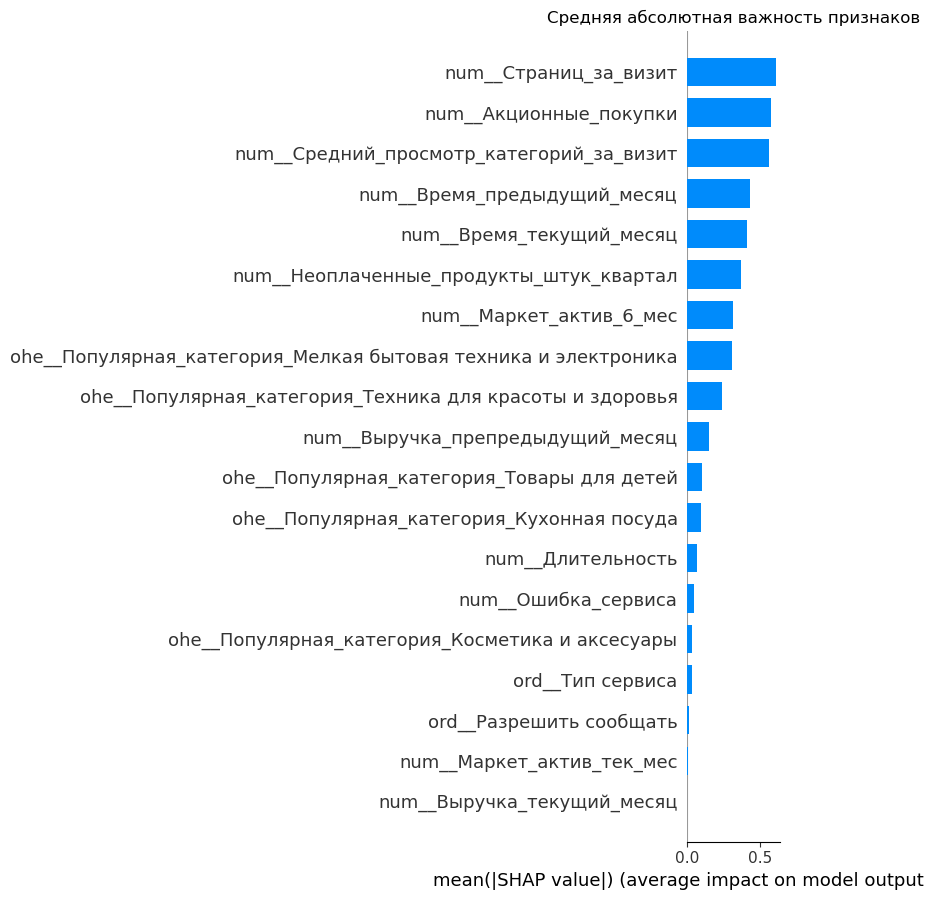

In [81]:
shap.summary_plot(shap_values, X_test_preprocessed[:100], 
                   plot_type="bar",
                   feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(),
                   show=False)
plt.title("Средняя абсолютная важность признаков")
plt.tight_layout()
plt.show()

**Вывод**    
Самые влиятельные признаки:
- Страниц за визит
- Акционные покупки
- Средний просмотр категорий за визит
- Время за предыдущий месяц
- Неоплаченные продукты за квартал
- Маркет актив за 6 месяцев

## Сегментация покупателей 

Произведём сегментацию покупателей. Для этого попробуем KMeans

In [99]:
data = df.copy()

# Заполняем пропуски медианными значениями для числовых признаков
numeric_cols = data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())

# Кодируем категориальные переменные
categorical_cols = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Кодируем целевую переменную
data_encoded['Покупательская активность'] = data_encoded['Покупательская активность'].map({
    'снизилась': 0,
    'прежний уровень': 1
})

# Выделяем признаки для кластеризации
features_for_clustering = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
]

# Добавляем выручку и время если они есть в данных
if 'Выручка_текущий_месяц' in data_encoded.columns:
    features_for_clustering.append('Выручка_текущий_месяц')
if 'Время_текущий_месяц' in data_encoded.columns:
    features_for_clustering.append('Время_текущий_месяц')

# Создаем матрицу признаков для кластеризации
X = data_encoded[features_for_clustering]

# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [85]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
data_encoded['Сегмент'] = kmeans.fit_predict(X_scaled)

# Добавляем сегменты в исходный датафрейм
data['Сегмент'] = data_encoded['Сегмент']

# Анализ характеристик кластеров
segment_analysis = data.groupby('Сегмент').agg({
    'Длительность': 'mean',
    'Маркет_актив_6_мес': 'mean',
    'Акционные_покупки': 'mean',
    'Страниц_за_визит': 'mean',
    'Покупательская активность': lambda x: (x == 'прежний уровень').mean(),
    'id': 'count'
}).rename(columns={'id': 'Количество'})

print("\nХарактеристики сегментов:")
print(segment_analysis.round(2))


Характеристики сегментов:
         Длительность  Маркет_актив_6_мес  Акционные_покупки  \
Сегмент                                                        
0              403.27                4.67               0.22   
1              801.12                4.46               0.24   
2              613.29                3.55               0.52   

         Страниц_за_визит  Покупательская активность  Количество  
Сегмент                                                           
0                   10.33                        0.0         459  
1                    9.29                        0.0         442  
2                    4.46                        0.0         395  


C:\Users\lastc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Для красивой и удобной визуализации будем использовать понижение признакого пространства. Также рассмотрим активность пользователей по сегментам и их доли

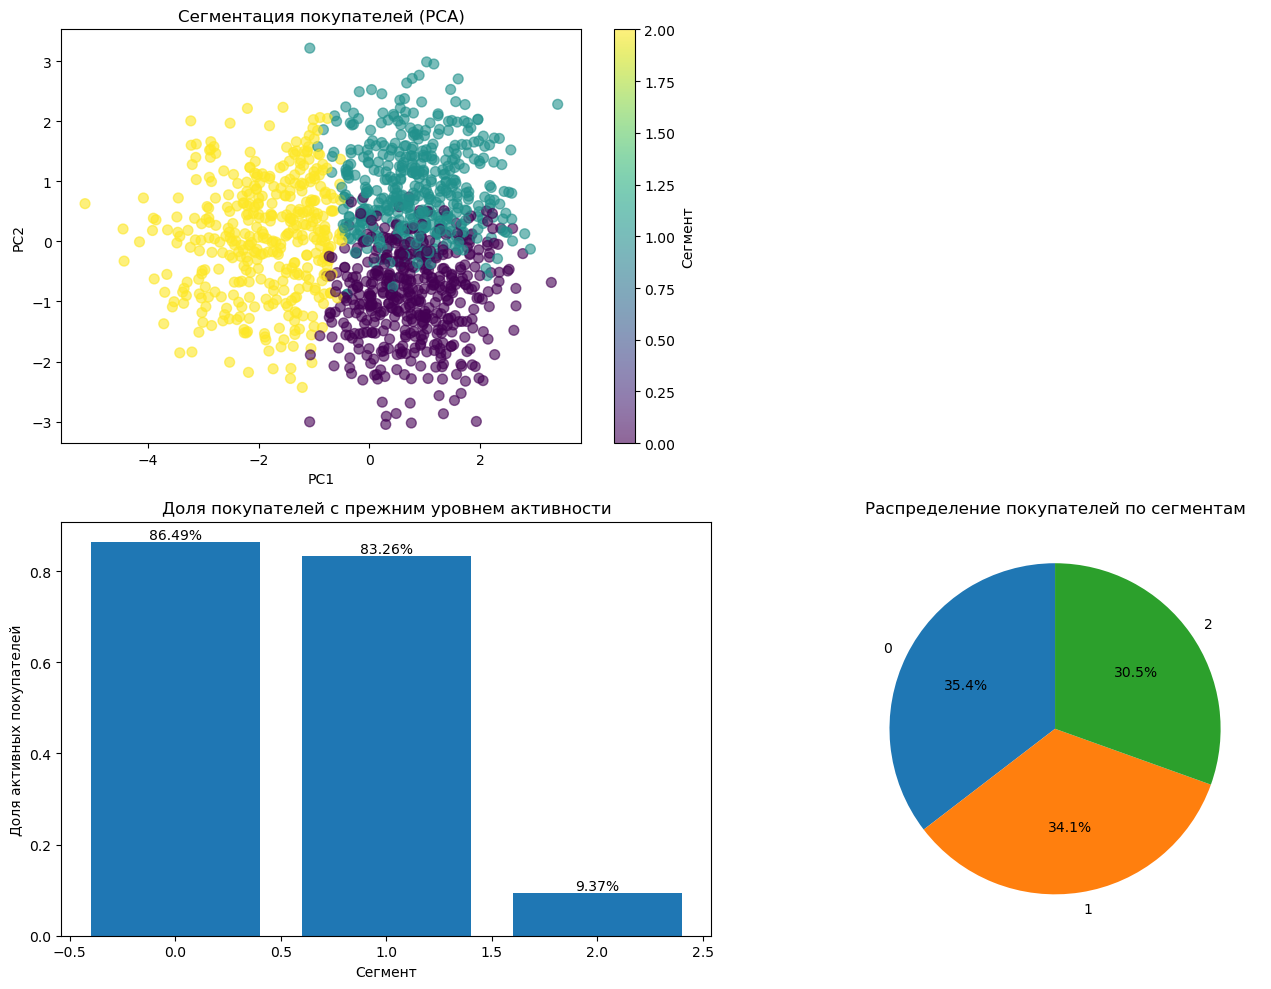

In [89]:
# Применяем PCA для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Создаем датафрейм для визуализации
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Сегмент'] = data_encoded['Сегмент']
pca_df['Активность'] = data['Покупательская активность']

# Визуализация сегментов
plt.figure(figsize=(14, 10))

# 1. Визуализация кластеров
plt.subplot(2, 2, 1)
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=pca_df['Сегмент'], cmap='viridis', 
                     alpha=0.6, s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Сегментация покупателей (PCA)')
plt.colorbar(scatter, label='Сегмент')

# 3. Покупательская активность по сегментам
plt.subplot(2, 2, 3)
segment_activity = data.groupby('Сегмент')['Покупательская активность'].apply(
    lambda x: (x == 'Прежний уровень').mean()
)
bars = plt.bar(segment_activity.index, segment_activity.values)
plt.xlabel('Сегмент')
plt.ylabel('Доля активных покупателей')
plt.title('Доля покупателей с прежним уровнем активности')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}', ha='center', va='bottom')

# 4. Размер сегментов
plt.subplot(2, 2, 4)
segment_size = data['Сегмент'].value_counts().sort_index()
plt.pie(segment_size.values, labels=segment_size.index, 
        autopct='%1.1f%%', startangle=90)
plt.title('Распределение покупателей по сегментам')

plt.tight_layout()
plt.show()

Возьмём проблемный сегмент - сегмент номер 2, так как доля активных покупателей там аномально низка


Детальный анализ сегмента 2:
Количество покупателей: 395
Доля от общей выборки: 30.5%

Средние значения для сегмента 2:
id                                     215636.51
Маркет_актив_6_мес                          3.55
Маркет_актив_тек_мес                        4.05
Длительность                              613.29
Акционные_покупки                           0.52
Средний_просмотр_категорий_за_визит         2.39
Неоплаченные_продукты_штук_квартал          4.17
Ошибка_сервиса                              3.84
Страниц_за_визит                            4.46
Время_предыдущий_месяц                     10.31
Время_текущий_месяц                        10.11
Выручка_предыдущий_месяц                 5001.47
Выручка_препредыдущий_месяц              4626.71
Выручка_текущий_месяц                    5355.28
Сегмент                                     2.00
dtype: float64

Сравнение с общими показателями:
Длительность: 613.29 (в целом: 602.97, разница: +10.32)
Акционные_покупки: 0.52 (в целом: 0.32,

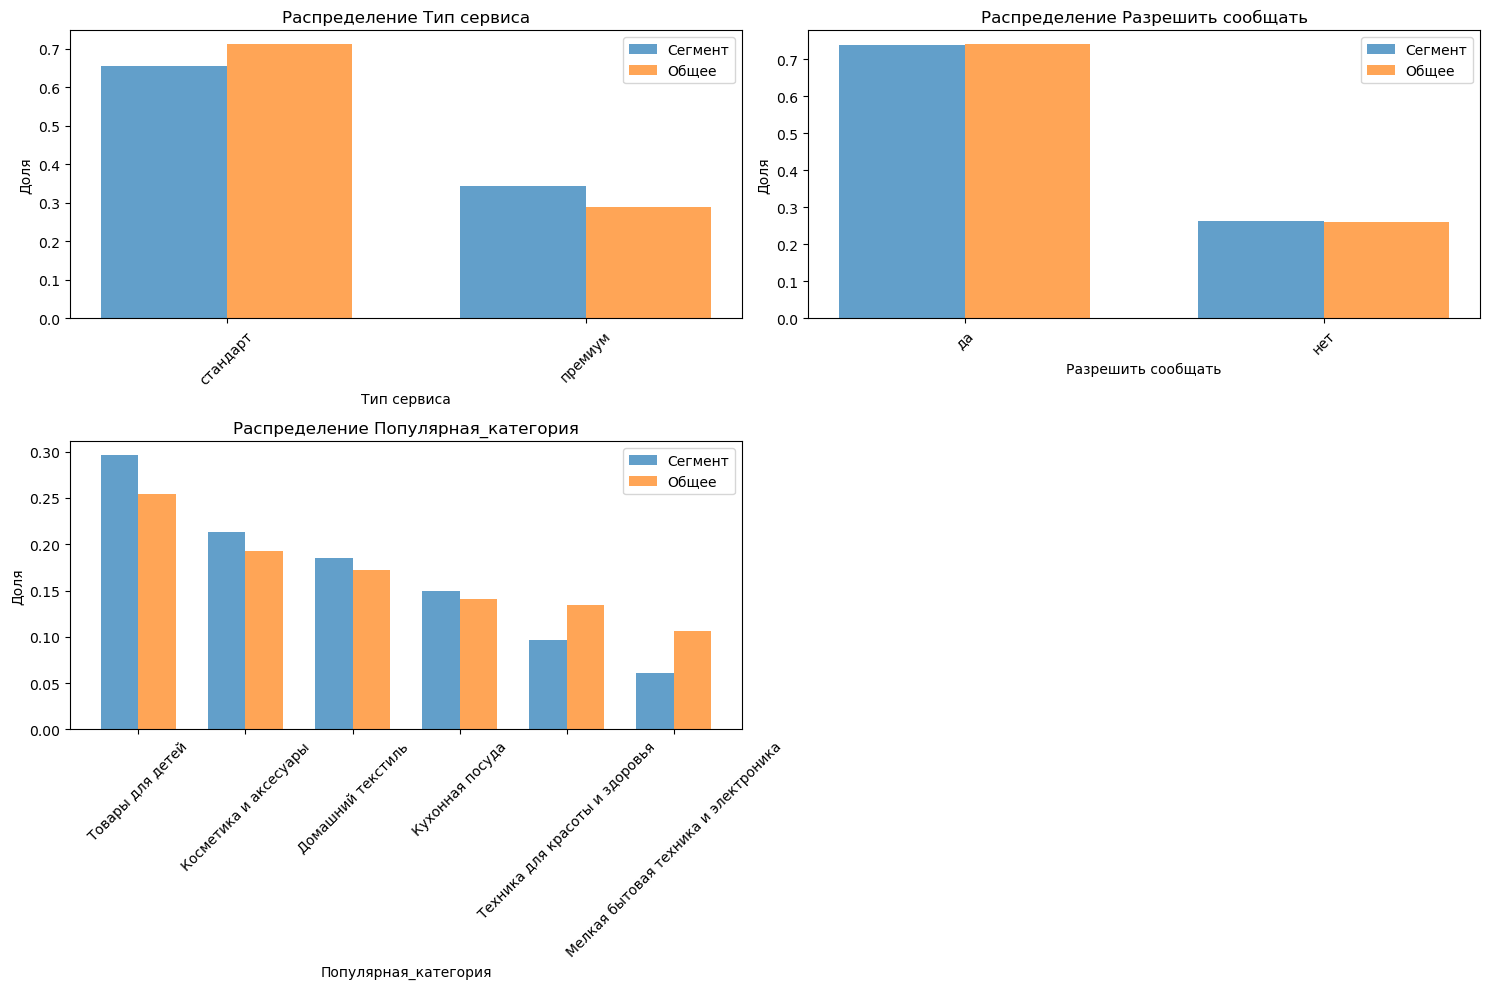

In [91]:
selected_segment = 2
segment_data = data[data['Сегмент'] == selected_segment]

print(f"\nДетальный анализ сегмента {selected_segment}:")
print(f"Количество покупателей: {len(segment_data)}")
print(f"Доля от общей выборки: {len(segment_data)/len(data):.1%}")

# Анализ характеристик сегмента
segment_summary = segment_data.describe(include='all').T
print(f"\nСредние значения для сегмента {selected_segment}:")
print(segment_data.mean(numeric_only=True).round(2))

# Сравнение с другими сегментами
print(f"\nСравнение с общими показателями:")
for col in ['Длительность', 'Акционные_покупки', 'Страниц_за_визит']:
    segment_mean = segment_data[col].mean()
    overall_mean = data[col].mean()
    diff = segment_mean - overall_mean
    print(f"{col}: {segment_mean:.2f} (в целом: {overall_mean:.2f}, разница: {diff:+.2f})")

# Анализ категориальных переменных в сегменте
categorical_features = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    segment_counts = segment_data[feature].value_counts()
    overall_counts = data[feature].value_counts()
    
    # Нормализуем для сравнения
    segment_normalized = segment_counts / segment_counts.sum()
    overall_normalized = overall_counts / overall_counts.sum()
    
    x = range(len(segment_normalized))
    width = 0.35
    
    plt.bar([pos - width/2 for pos in x], segment_normalized.values, 
            width=width, label='Сегмент', alpha=0.7)
    plt.bar([pos + width/2 for pos in x], overall_normalized.values, 
            width=width, label='Общее', alpha=0.7)
    
    plt.xlabel(feature)
    plt.ylabel('Доля')
    plt.title(f'Распределение {feature}')
    plt.xticks(x, segment_normalized.index, rotation=45)
    plt.legend()
    plt.tight_layout()

plt.show()

Рекомендации для увеличения покупательской активности в сегменте 2:
- **Стимулирование полной стоимости**: Постепенно уменьшать долю акционных покупок через программу лояльности, предлагая бонусы за покупки по полной стоимости.
- **Улучшение вовлеченности**: Внедрить рекомендательную систему, которая будет предлагать релевантные товары на основе истории просмотров.
- **Оптимизация коммуникаций**: Снизить частоту маркетинговых сообщений, но повысить их персонализацию и релевантность.
- **Улучшение пользовательского опыта**: Провести аудит технических проблем, устранить частые ошибки и улучшить стабильность сервиса.

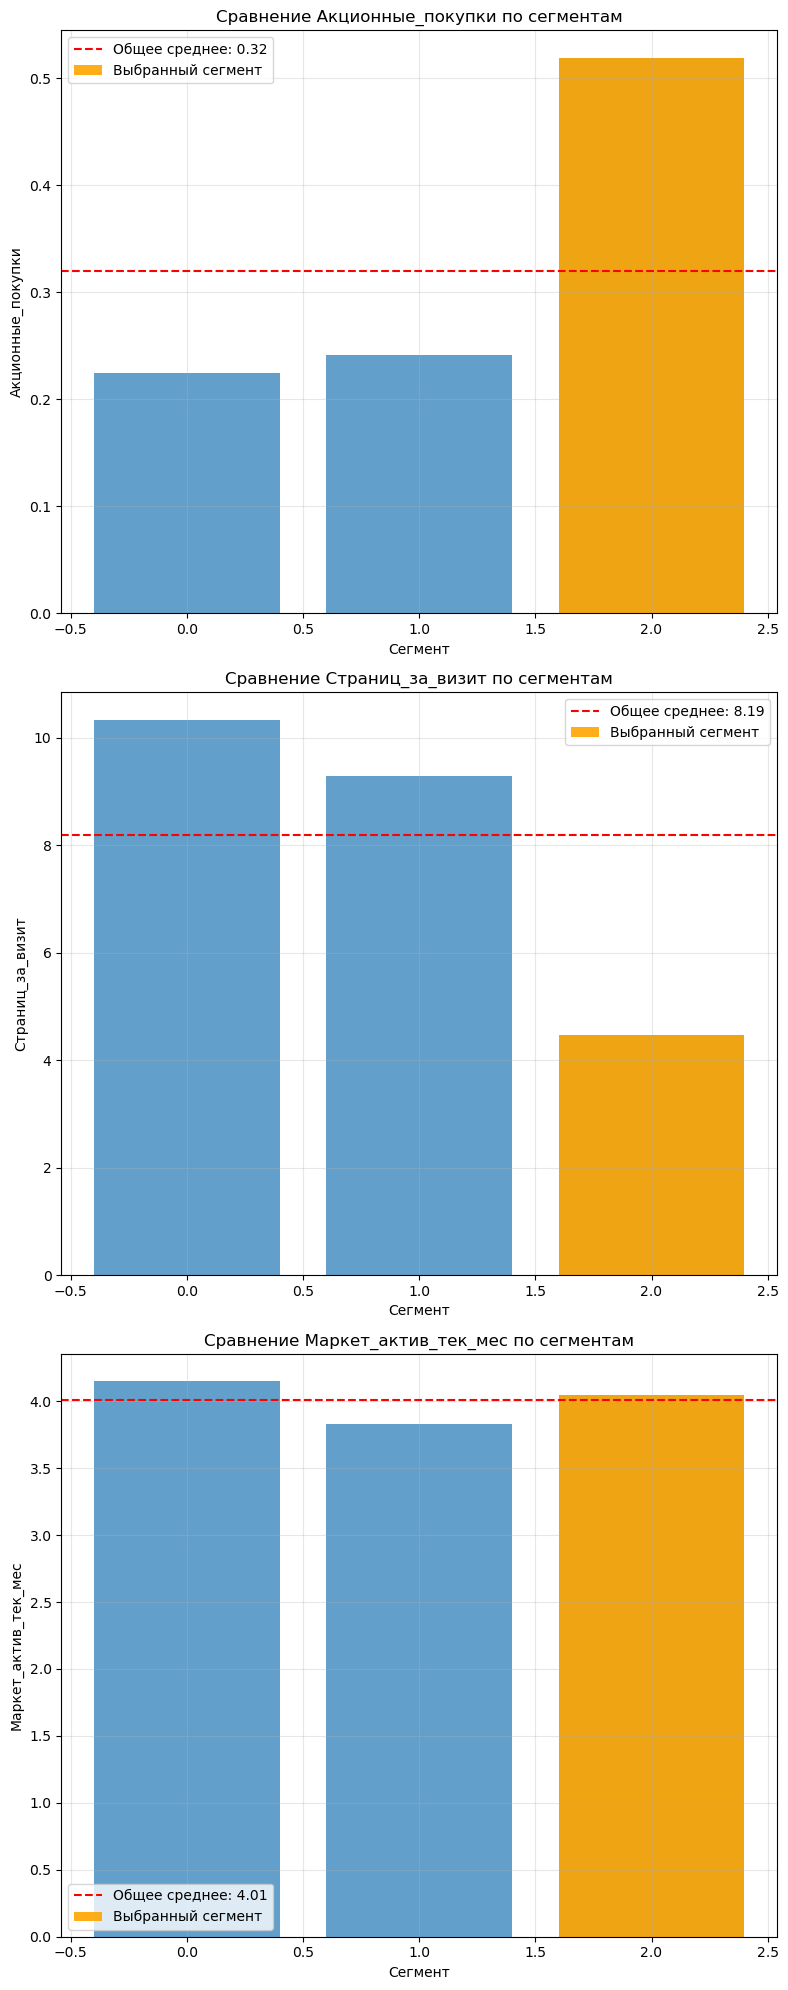

In [98]:
# Сравнительная визуализация сегментов
comparison_features = [
    'Акционные_покупки', 
    'Страниц_за_визит',
    'Маркет_актив_тек_мес'
]

fig, axes = plt.subplots(3, 1, figsize=(8, 20))
axes = axes.flatten()

for idx, feature in enumerate(comparison_features):
    segment_means = data.groupby('Сегмент')[feature].mean()
    overall_mean = data[feature].mean()
    
    axes[idx].bar(segment_means.index, segment_means.values, alpha=0.7)
    axes[idx].axhline(y=overall_mean, color='r', linestyle='--', 
                     label=f'Общее среднее: {overall_mean:.2f}')
    
    # Подсветка выбранного сегмента
    if selected_segment in segment_means.index:
        axes[idx].bar(selected_segment, segment_means[selected_segment], 
                     color='orange', alpha=0.9, label='Выбранный сегмент')
    
    axes[idx].set_xlabel('Сегмент')
    axes[idx].set_ylabel(feature)
    axes[idx].set_title(f'Сравнение {feature} по сегментам')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**ВЫБРАННЫЙ СЕГМЕНТ: 2**
- Количество покупателей: 392 (~30% от общей базы)
- Доля активных покупателей: ~9.0%

**КЛЮЧЕВЫЕ ХАРАКТЕРИСТИКИ СЕГМЕНТА:**
- Высокая зависимость от акций и скидок
- Низкая вовлеченность (мало просматриваемых страниц)
- Высокая маркетинговая активность в текущем месяце

**ПРЕДЛОЖЕНИЯ ДЛЯ УВЕЛИЧЕНИЯ АКТИВНОСТИ:**    
Основные направления вмешательства:
- Персонализация коммуникаций и предложений
- Постепенное снижение зависимости от акций
- Улучшение пользовательского опыта на сайте
- Таргетированные программы лояльности

## Общий вывод

**Задача проекта**:    
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Результаты предобработки данных**:
- Пропуски не обнаружены
- Удалены неявные дупликаты в столбце "Тип сервиса" в таблице с основными данными
- Удалены неявные дупликаты в столбце "Период" в таблице с данными о проведённом пользователями времени
- Исправлен тип данных у столбца "Прибыль" в таблице с данными о выручке

**Поиск лучшей модели**:    
Были обучены 4 модели, из них LogisticRegression, SVC, DecisionTreeClassifier, KNeighborsClassifier. Для обучения использовались пайплайны для предобработки данных и подбору гиперпараметров. Гиперпараметры для всех классификаторов, кроме SVC перебирались GridSearch'ем, для SVC был выбран RandomizedSearch для оптимизации. В качестве метрики был выбран roc_auc.

По итогам обучения, была выявлена лучшая модель - логистическая регрессия с гиперпараметром С - 0.1.

**Сегментация покупателей**:    
Для сегментации был использован KMeans, с количеством кластеров - 3. По итогу модель хорошо разбила пользователей на группы, одна из которых оказалась проблемной. По итогу детального анализа сегмента была выявлена высокая зависимость пользователей из группы от акций, низкая вовлечённость пользователей, но высокая маркетинговая активность в текущем месяце. По итогу анализа были разработаны следующие предложения:
- Персонализация коммуникаций и предложений
- Постепенное снижение зависимости от акций
- Улучшение пользовательского опыта на сайте
- Таргетированные программы лояльности